#### Import Library

In [42]:
# Imports
import numpy as np
import time
import random
from tqdm import tqdm
import os
import pandas as pd
import cv2
from collections import deque
import PIL
from PIL import Image
import csv
import pandas as pd
import pickle

#### Main Parameter

In [43]:
MODEL_NAME = 'qn_singlestate-unique'
EPISODES = 300
MAX_STEP = 10000


#### Parameter

In [44]:
# Parameters
MAP_X = 30
MAP_Y = 20
GRID_SIZE = 0.5
SIZE_X = int(MAP_X/GRID_SIZE)
SIZE_Y = int(MAP_Y/GRID_SIZE)
pathDist_path = f'scripts/path_dist/{MAP_X}x{MAP_Y}_pathDistv3.csv'


STATE_SIZE = 1
ACTION_SIZE = 8


# Exploration settings
epsilon = 1  # not a constant, going to be decayed
EPSILON_DECAY = 0.9
MIN_EPSILON = 0.001
DISCOUNT = 0.99


# Environment settings
####################################################

####################################################

SAVE_EVERY = 1 #each step

LEARNING_RATE = 0.1
DISCOUNT = 0.95
TARGET_REWARD = 100

GRID_MAX = 2 # For obstacle detection

#### Environment Setup

In [45]:

# Define Functions and Classes
def createLine(walls, SIZE_Y, SIZE_X):
    # Full Horizontal Line
    # for i in range(SIZE_X):
    #     walls[int(SIZE_Y/2),int(i)] = 1

    # Full Vertical Line
    # for i in range(SIZE_Y):
    # walls[int(i), int(SIZE_X/2)] = 1

    # Segment 1
    for i in range(SIZE_Y//10, SIZE_Y//3):
        walls[i, SIZE_X//2] = 1

    # Segment 2
    for i in range(SIZE_X//2, SIZE_X//2+SIZE_X//6):
        walls[SIZE_Y//10, i] = 1

    # Segment 3
    for i in range(SIZE_Y//10, SIZE_Y//4):
        walls[i, SIZE_X//2+SIZE_X//6] = 1

    # Segment 4
    for i in range(SIZE_X//2-SIZE_X//6, SIZE_X//2+1):
        walls[SIZE_Y//3, i] = 1

    # Segment 5
    for i in range(SIZE_Y//3, SIZE_Y//3+SIZE_Y//4):
        walls[i, SIZE_X//2-SIZE_X//6] = 1

    # Segment 6
    for i in range(SIZE_X//2-SIZE_X//6, SIZE_X//2+SIZE_X//6):
        walls[SIZE_Y//3+SIZE_Y//4, i] = 1

    # Segment 7
    for i in range(SIZE_Y//3+SIZE_Y//4, SIZE_Y//3+SIZE_Y//4+SIZE_Y//5):
        walls[i, SIZE_X//2+SIZE_X//6] = 1

    # Segment 8
    for i in range(SIZE_X//2+SIZE_X//6, SIZE_X//2+SIZE_X//6+SIZE_X//6):
        walls[SIZE_Y//3+SIZE_Y//4+SIZE_Y//5, i] = 1

    # Segment 9
    for i in range(SIZE_Y-SIZE_Y//3, SIZE_Y):
        walls[i, SIZE_X//2] = 1

    # Segment 10
    for i in range(SIZE_Y-SIZE_Y//4, SIZE_Y):
        walls[i, SIZE_X//2-SIZE_X//4] = 1

    # Segment 11
    for i in range(0, SIZE_X//6):
        walls[SIZE_Y//5, i] = 1

    # Segment 12
    for i in range(SIZE_Y//5, SIZE_Y//5+SIZE_Y//5):
        walls[i, SIZE_X//6] = 1

    # Segment 13
    for i in range(0, SIZE_X//6):
        walls[SIZE_Y//5+SIZE_Y//3, i] = 1

    # Segment 14
    for i in range(0, SIZE_Y//3):
        walls[i, SIZE_X-SIZE_X//6] = 1

    # Segment 15
    for i in range(SIZE_X-SIZE_X//10, SIZE_X):
        walls[SIZE_Y//3, i] = 1

    # Segment 16
    for i in range(SIZE_X-SIZE_X//9, SIZE_X):
        walls[SIZE_Y//2+SIZE_Y//10, i] = 1

    # Segment 17
    for i in range(SIZE_Y//2+SIZE_Y//10, SIZE_Y//2+SIZE_Y//10+SIZE_Y//4):
        walls[i, SIZE_X-SIZE_X//9] = 1

    # Segment 18
    for i in range(SIZE_Y//2+SIZE_Y//10+SIZE_Y//3, SIZE_Y):
        walls[i, SIZE_X-SIZE_X//9] = 1

    return walls


class EnvObject:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __str__(self):
        return f"{self.x}, {self.y}"

    def __sub__(self, other):
        return (self.x - other.x, self.y - other.y)

    def __eq__(self, other):
        return self.x == other.x and self.y == other.y


class Drone(EnvObject):
    def __init__(self, x, y):
        super().__init__(x, y)

    def action(self, choice, walls = None):
        '''
        Gives us 9 total movement options. (0,1,2,3,4,5,6,7,8)
        '''
        # if choice == 0:
        #     x = 0
        #     y = 0
            
        if choice == 0:
            x=-1
            y=-1
        elif choice == 1:
            x=-1
            y=1
        elif choice == 2:
            x=1
            y=-1
        elif choice == 3:
            x=1
            y=1
            
        elif choice == 4:
            x=1
            y=0
        elif choice == 5:
            x=-1
            y=0
            
        elif choice == 6:
            x=0
            y=1
        elif choice == 7:
            x=0
            y=-1
        
        self.move(x=x, y=y, walls=walls)
            

    def move(self, x=0, y=0, walls = None):
        #if no value for x or y, stay
        
        x,y = self.collisionCheck(x,y,walls)
        self.x += x
        self.y += y

            
    def collisionCheck(self, x=0, y=0, walls=None):
        #checking for out of bounds
        predict_x = self.x + x
        predict_y = self.y + y
        if predict_x < 0 or predict_x > SIZE_X-1:
            x = 0
        if predict_y < 0 or predict_y > SIZE_Y-1:
            y = 0
            
        
        # Check for collision with walls    
        if walls is None:
            return x,y
        elif walls[self.y+y][self.x+x] == 1:
            return 0,0
        else:
            return x,y
    
    def detectObstacle(self, walls):
        self.obstacle = np.zeros((8, ), dtype=np.uint8)
        
        for grid in range(1, GRID_MAX+1):
            for x in range(-1, 2):
                for y in range(-1,2):
                    if (self.x + grid*x > 0 and self.x + grid*x < SIZE_X-1) and (self.y + grid*y > 0 and self.y + grid*y < SIZE_Y-1):
                        print(x*grid,y*grid)
                        if walls[self.y+grid*y][self.x+grid*x] == 1 and (x == 0 and y==1):
                            self.obstacle[4] += (GRID_MAX-grid+1)
                        elif walls[self.y+grid*y][self.x+grid*x] == 1 and (x == 1 and y==1):
                            self.obstacle[3] += (GRID_MAX-grid+1)
                        elif walls[self.y+grid*y][self.x+grid*x] == 1 and (x == 1 and y==0):
                            self.obstacle[2] += (GRID_MAX-grid+1)
                        elif walls[self.y+grid*y][self.x+grid*x] == 1 and (x == 1 and y==-1):
                            self.obstacle[1] += (GRID_MAX-grid+1)
                        elif walls[self.y+grid*y][self.x+grid*x] == 1 and (x == 0 and y==-1):
                            self.obstacle[0] += (GRID_MAX-grid+1)
                        elif walls[self.y+grid*y][self.x+grid*x] == 1 and (x == -1 and y==-1):
                            self.obstacle[7] += (GRID_MAX-grid+1)
                        elif walls[self.y+grid*y][self.x+grid*x] == 1 and (x == -1 and y==0):
                            self.obstacle[6] += (GRID_MAX-grid+1)
                        elif walls[self.y+grid*y][self.x+grid*x] == 1 and (x == -1 and y==1):
                            self.obstacle[5] += (GRID_MAX-grid+1)
                        print('grid: ', grid, 'obstacle:', self.obstacle)
        # self.obstacle[0] += 2
        return self.obstacle


class Target(EnvObject):
    def __init__(self, x, y):
        super().__init__(x, y)


class DroneEnv:
    # Define Parameters
    SIZE_X = SIZE_X
    SIZE_Y = SIZE_Y
    ENV_COLOR = (20, 52, 89)
    WALLS_COLOR = (77, 77, 234)
    DRONE_COLOR = (234, 222, 53)
    TARGET_COLOR = (132, 234, 53)
    space = np.zeros((SIZE_Y, SIZE_X, 3), dtype=np.uint8)
    walls = createLine(
        np.zeros((SIZE_Y, SIZE_X), dtype=np.uint8), SIZE_Y, SIZE_X)
    pathDist = pd.read_csv(f'{pathDist_path}', header=None, dtype='Float32').values
    
    def reset(self):
        # self.agent_1 = Drone(self.SIZE_X-self.SIZE_X//11, self.SIZE_Y//10)
        self.agent_1 = Drone(55,12)
        self.agent_3 = Drone(self.SIZE_X-self.SIZE_X//13,
                             self.SIZE_Y-self.SIZE_Y//11)
        self.target = Target(SIZE_X//10, self.SIZE_Y//2-self.SIZE_Y//20)

        self.episode_step = 0

        observation = (self.pathDist[self.agent_1.y][self.agent_1.x])
        return observation

    def step(self, action, observation):
        reward = 0
        done= False
        self.episode_step += 1
        self.agent_1.action(action, self.walls)

        new_observation = (self.pathDist[self.agent_1.y][self.agent_1.x]) 
        # if self.agent_1 == self.target:
        if (new_observation <= 10) :
            reward = TARGET_REWARD
            done = True
        elif self.episode_step >= MAX_STEP:
            reward = -10
            done = True
        else:
            reward = 1.5*(observation - new_observation)/10 - 0.5
            done = False
            
        return new_observation, reward, done

    def visualize(self):
        for i in range(self.SIZE_Y):
            for j in range(self.SIZE_X):
                if self.walls[i][j] == 1:
                    self.space[i][j] = self.WALLS_COLOR
                else:
                    self.space[i][j] = self.ENV_COLOR

        self.space[self.agent_1.y][self.agent_1.x] = self.DRONE_COLOR
        self.space[self.target.y][self.target.x] = self.TARGET_COLOR

    def render(self):
        self.visualize()
        img = Image.fromarray(self.space, 'RGB')
        img = img.resize((1200, 800), resample=Image.Resampling.BOX)
        cv2.imshow("image", np.array(img))  # show it!
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    def saveImage(self, image_path, episode='e', step='s'):
        self.visualize()
        if not os.path.isdir(image_path):
            os.makedirs(image_path)

        img = Image.fromarray(self.space, 'RGB')
        # img = img.resize((1200, 800), resample=Image.Resampling.BOX)
        img_rgb = img.convert('RGB')
        img_rgb = img_rgb.save(f'{image_path}/episode_{episode}/image_{episode}_{step}.png')
        

#### Initialization

In [46]:
env = DroneEnv()
header = ['episode', 'step', 'episode_reward', 'epsilon', 'x_position', 'y_position']
header_episode = ['episode', 'episode_reward']
episode_rewards = []
csvPrints = []
csvPrintEpisodes = []

if not os.path.isdir('images'):
    os.makedirs('images')
#for episode in range(1, EPISODES+1):
    #os.makedirs(f'images/episode_{episode}')

start_q_table = None  # if we have a pickled Q table, we'll put the filename of it here.

if start_q_table is None:
    q_table = {}
    for i in range(0, 1000):
        q_table[(i)] = [np.random.uniform(-5, 0) for i in range(ACTION_SIZE)]
else:
    with open(start_q_table, "rb") as f:
        q_tablle = pickle.load(f)     
                


#### Main Loop

In [47]:
RUNS = 100

In [48]:
for run in range(RUNS):
    epsilon = 1
    env = DroneEnv()
    header = ['episode', 'step', 'episode_reward', 'epsilon', 'x_position', 'y_position']
    header_episode = ['episode', 'episode_reward']
    episode_rewards = []
    csvPrints = []
    csvPrintEpisodes = []

    if not os.path.isdir(f'outputs/{MODEL_NAME}/'):
        os.makedirs(f'outputs/{MODEL_NAME}/')
    #for episode in range(1, EPISODES+1):
        #os.makedirs(f'images/episode_{episode}')

    start_q_table = None  # if we have a pickled Q table, we'll put the filename of it here.

    if start_q_table is None:
        q_table = {}
        for i in range(0, 1000):
            q_table[(i)] = [np.random.uniform(-5, 0) for i in range(ACTION_SIZE)]
    else:
        with open(start_q_table, "rb") as f:
            q_table = pickle.load(f)
     
    for episode in range(1, EPISODES+1):
        agent_1 = Drone(SIZE_X-SIZE_X//11, SIZE_Y//10)
        target = Target(SIZE_X//10, 3*SIZE_Y//4)
        episode_reward = 0

        current_state = env.reset()
        
        done = False
        while not done:
            current_state = (env.pathDist[env.agent_1.y][env.agent_1.x])
            
            if np.random.random() > epsilon:
                action = np.argmax(q_table[current_state])
            else:
                action = np.random.randint(0, ACTION_SIZE)
            
            new_state, reward, done = env.step(action, current_state)
            
            max_future_q = np.max(q_table[new_state])
            current_q = q_table[current_state][action]
            
            if reward == TARGET_REWARD:
                new_q = TARGET_REWARD
            else:
                new_q =  (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
                
            q_table[current_state][action] = new_q

            episode_reward += reward
            
            if reward == TARGET_REWARD:
                print(f'Episode: {episode}, steps: {env.episode_step}, episode reward: {episode_reward}, epsilon: {epsilon}')
                break
            
            #if env.episode_step % SAVE_EVERY == 0:
                #env.saveImage(f'outpus/images/{MODEL_NAME}', episode, env.episode_step)

            episode_rewards.append(episode_reward)  
            
            csvPrint = [episode, env.episode_step, episode_reward, epsilon, env.agent_1.x, env.agent_1.y,env.pathDist[env.agent_1.y][env.agent_1.x]]
            csvPrints.append(csvPrint)
        
        csvPrintEpisodes.append([episode, episode_reward, env.episode_step,  epsilon])
        if epsilon > MIN_EPSILON:
            epsilon *= EPSILON_DECAY      

    with open(f'outputs/{MODEL_NAME}/Run{run}.csv', 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)

        # write the header
        writer.writerow(header)

        # write multiple rows
        writer.writerows(csvPrints)     

Episode: 2, steps: 3097, episode reward: -1360.699999999997, epsilon: 0.9
Episode: 3, steps: 6462, episode reward: -3043.200000000003, epsilon: 0.81
Episode: 4, steps: 773, episode reward: -198.8499999999999, epsilon: 0.7290000000000001
Episode: 5, steps: 789, episode reward: -207.2999999999996, epsilon: 0.6561000000000001
Episode: 6, steps: 462, episode reward: -43.350000000000165, epsilon: 0.5904900000000002
Episode: 7, steps: 453, episode reward: -38.700000000000074, epsilon: 0.5314410000000002
Episode: 8, steps: 339, episode reward: 18.44999999999996, epsilon: 0.47829690000000014
Episode: 9, steps: 426, episode reward: -25.350000000000023, epsilon: 0.43046721000000016
Episode: 10, steps: 272, episode reward: 51.650000000000006, epsilon: 0.38742048900000015
Episode: 11, steps: 955, episode reward: -289.7000000000008, epsilon: 0.34867844010000015
Episode: 12, steps: 222, episode reward: 76.65, epsilon: 0.31381059609000017
Episode: 13, steps: 142, episode reward: 116.8, epsilon: 0.282

#### Save Data

In [49]:
   
with open(f'outputs/csv/{MODEL_NAME}.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write multiple rows
    writer.writerows(csvPrints)

with open(f'outputs/csv/{MODEL_NAME}_episode.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header_episode)

    # write multiple rows
    writer.writerows(csvPrintEpisodes)


with open(f"outputs/qtables/qtable-{MODEL_NAME}-{int(time.time())}.pickle", "wb") as f:
    pickle.dump(q_table, f)

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/csv/qn_singlestate-unique.csv'

#### Create Plot

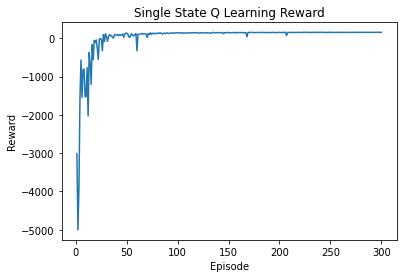

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (6,4))
plt.title('Single State Q Learning Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.plot([i[0] for i in csvPrintEpisodes], [i[1] for i in csvPrintEpisodes])

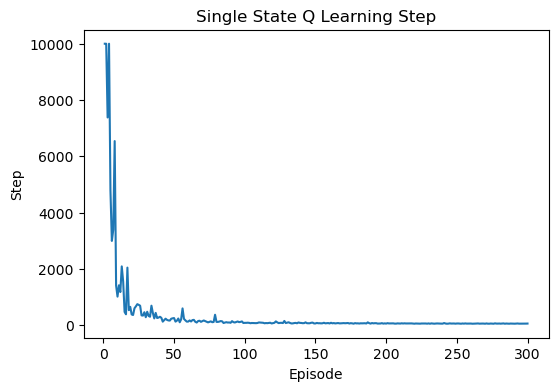

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (6,4))
plt.title('Single State Q Learning Step')
plt.xlabel('Episode')
plt.ylabel('Step')
plt.plot([i[0] for i in csvPrintEpisodes], [i[2] for i in csvPrintEpisodes])

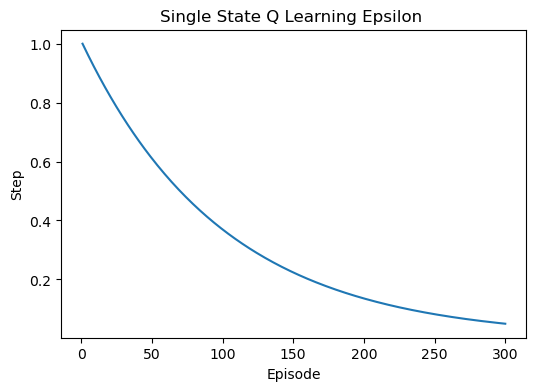

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (6,4))
plt.title('Single State Q Learning Epsilon ')
plt.xlabel('Episode')
plt.ylabel('Step')
plt.plot([i[0] for i in csvPrintEpisodes], [i[3] for i in csvPrintEpisodes])